**RBF Training**

Si aun no ha instalado keras y tensorflow:

    pip install keras
    pip install tensorflow
    pip install opencv-python

In [1]:
from __future__ import print_function
from sklearn.gaussian_process.kernels import PairwiseKernel
import keras
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist # Base de datos de dígitos manuscritos: 60,000 28x28 grayscale + 10,000 test
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

# Los datos, mezclados y divididos entre entrenamiento y de prueba
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Cambio de matriz a array --> dimensión 28x28 a array de dimensión 784
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Cambio de tipo de datos a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Escalar los datos para que estén entre 0 y 1
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convertir vectores en matrices binarias 
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# K-means clustering para encontrar centros
size = 40
kmeans_model = KMeans(size)   #find 10 centers with kmeans on training samples
kmeans_model.fit(x_train)
centers = kmeans_model.cluster_centers_
x = kmeans_model.predict(kmeans_model.cluster_centers_)
x = keras.utils.to_categorical(x, size)

y_trainn= kmeans_model.predict(x_train)
y_trainn=keras.utils.to_categorical(y_trainn, size)
y_testt=kmeans_model.predict(x_test)
y_testt=keras.utils.to_categorical(y_testt, size)


#                       RBF LAYER

kernel = PairwiseKernel(metric='polynomial')   #GPR uses the kernel to define the covariance of the training sample
rbf_model = GaussianProcessRegressor(kernel=kernel).fit(centers, x)

temp1 = rbf_model.predict(x_train)
temp2 = rbf_model.predict(x_test)


#                      PERCEPTRONS LAYERS
batch_size = 128
epochs = 10
img_size = 28 * 28

model = Sequential()
model.add(Dense(img_size, activation='relu', input_shape=(size,)))
model.add(Dropout(0.2))
model.add(Dense(size, activation='softmax'))

model.summary()
nadam=keras.optimizers.Nadam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

#                      TRAINING THE MODEL
history = model.fit(temp1, y_trainn,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(temp2, y_testt))

#                      EVALUATE TRAINED MODEL
score = model.evaluate(temp2, y_testt, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


11501568/11490434 [==============================] - 7s 1us/step
60000 train samples
10000 test samples


W0627 02:06:22.448585 140683798554112 deprecation_wrapper.py:119] From /home/fredymar/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 02:06:22.466645 140683798554112 deprecation_wrapper.py:119] From /home/fredymar/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 02:06:22.470444 140683798554112 deprecation_wrapper.py:119] From /home/fredymar/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 02:06:22.484838 140683798554112 deprecation_wrapper.py:119] From /home/fredymar/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               32144     
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                31400     
Total params: 63,544
Trainable params: 63,544
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 21us/step - loss: 1.3757 - acc: 0.8111 - val_loss: 0.4735 - val_acc: 0.8971
Epoch 2/10
60000/60000 [==============================] - 1s 18us/step - loss: 0.3666 - acc: 0.9112 - val_loss: 0.2961 - val_acc: 0.9200
Epoch 3/10
60000/60000 [==============================] - 1s 18us/step - loss:

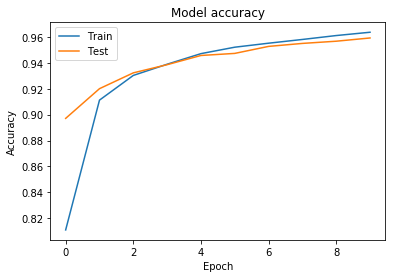

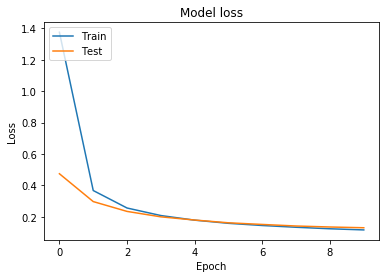

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(40, 784)
(784,)
(784, 40)
(40,)


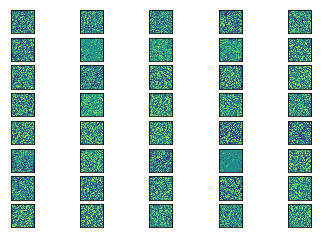

In [5]:
for i in range(len(model.get_weights())):
  print(model.get_weights()[i].shape)
weights = model.get_weights()[0]
for i in range(len(weights)):
  ax = plt.subplot(len(weights)/5, 5, i + 1)
  plt.imshow(weights[i].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

center [array([0.61616162]), array([-0.09090909]), array([0.87878788]), array([-0.03030303]), array([0.83838384]), array([-0.95959596]), array([-0.01010101]), array([0.23232323]), array([-0.31313131]), array([-0.77777778])]
[[8.41506855e-10 1.34471895e-03 5.44585659e-13 5.40780169e-04
  1.81082043e-12 9.87025018e-01 3.93984070e-04 5.29385210e-06
  2.29529515e-02 6.73638455e-01]
 [1.41420789e-09 1.79816666e-03 9.96296840e-13 7.37440410e-04
  3.26983696e-12 9.96740351e-01 5.40780169e-04 7.85859545e-06
  2.85655008e-02 7.21446326e-01]
 [2.36120088e-09 2.38886957e-03 1.81082043e-12 9.99072922e-04
  5.86598424e-12 1.00000000e+00 7.37440410e-04 1.15899655e-05
  3.53190672e-02 7.67618196e-01]
 [3.91666743e-09 3.15296404e-03 3.26983696e-12 1.34471895e-03
  1.04548972e-11 9.96740351e-01 9.99072922e-04 1.69817887e-05
  4.33851086e-02 8.11429096e-01]
 [6.45452870e-09 4.13437319e-03 5.86598424e-12 1.79816666e-03
  1.85123998e-11 9.87025018e-01 1.34471895e-03 2.47200191e-05
  5.29463752e-02 8.52157

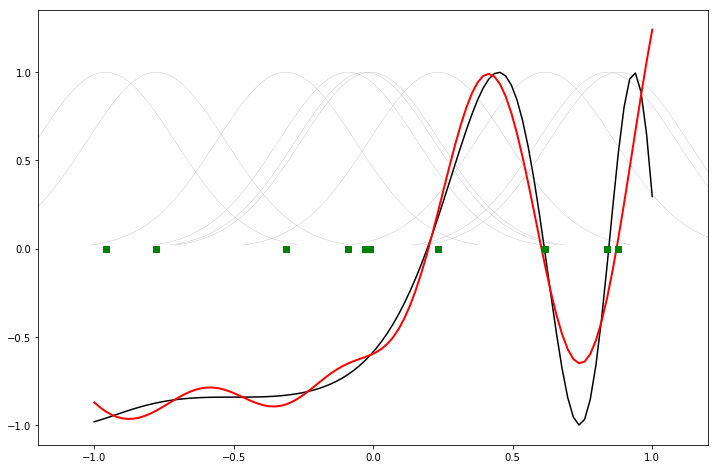

In [6]:
from scipy import *
from scipy.linalg import norm, pinv
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return exp(-self.beta * norm(c-d)**2)
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = dot(G, self.W)
        return Y
 
      
if __name__ == '__main__':
    # ----- 1D Example ------------------------------------------------
    n = 100
     
    x = mgrid[-1:1:complex(0,n)].reshape(n, 1)
    # set y and add random noise
    y = sin(3*(x+0.5)**3 - 1)
    # y += random.normal(0, 0.1, y.shape)
     
    # rbf regression
    rbf = RBF(1, 10, 1)
    rbf.train(x, y)
    z = rbf.test(x)
       
    # plot original data
    plt.figure(figsize=(12, 8))
    plt.plot(x, y, 'k-')
     
    # plot learned model
    plt.plot(x, z, 'r-', linewidth=2)
     
    # plot rbfs
    plt.plot(rbf.centers, zeros(rbf.numCenters), 'gs')
     
    for c in rbf.centers:
        # RF prediction lines
        cx = arange(c-0.7, c+0.7, 0.01)
        cy = [rbf._basisfunc(array([cx_]), array([c])) for cx_ in cx]
        plt.plot(cx, cy, '-', color='gray', linewidth=0.2)
     
    plt.xlim(-1.2, 1.2)
    plt.show()